,name,estimate,std,low_95,high_95,guess,fixed,lower_bound,upper_bound,prior_mean,prior_std
name,,,,,,,,,,,
m0,m0,4.993215,0.007323,4.978448,5.007982,5.0,False,-inf,inf,NaN,NaN
s0,s0,0.297312,0.008716,0.279735,0.314890,1.0,False,0.0,inf,NaN,NaN
a0,a0,9.920214,0.351987,9.210364,10.630063,1.0,False,0.0,inf,NaN,NaN
m1,m1,6.033778,0.101307,5.829472,6.238083,7.0,False,-inf,inf,NaN,NaN
s1,s1,1.378025,0.074885,1.227004,1.529046,1.0,False,0.0,inf,NaN,NaN
a1,a1,9.629073,0.582081,8.455196,10.802951,1.0,False,0.0,inf,NaN,NaN


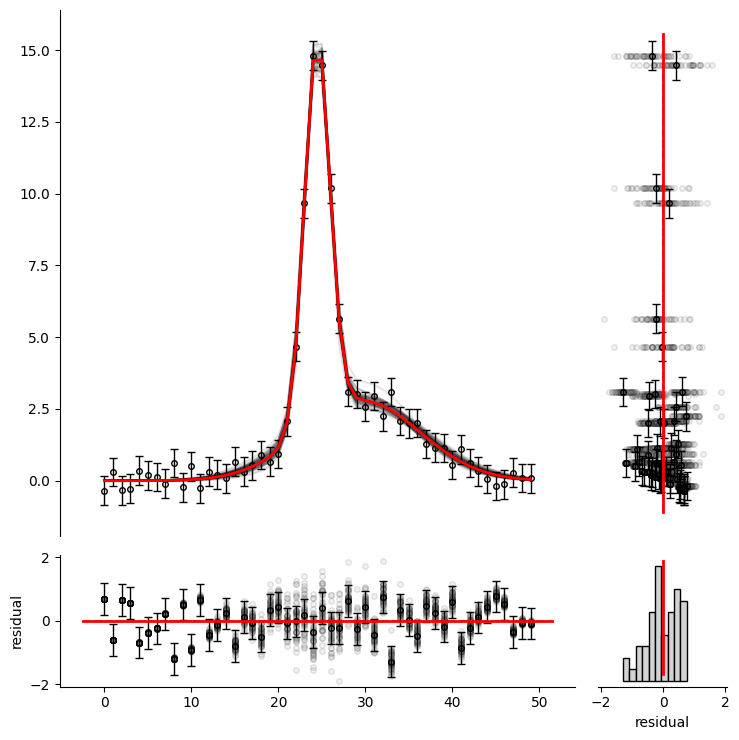

In [1]:
%matplotlib inline
import dataprob
import numpy as np
from scipy import stats

def multi_gaussian(params,num_gaussians,x):
    """
    Generate a multi-guassian.

    Parameters
    ----------
    params : numpy.ndarray
        float numpy array that is num_gaussians*3 long. this encodes the
        gaussian [mean1,std1,area1,mean2,std2,area2,...meanN,stdN,areaN]
        shape parameters
    num_gaussians : int
        number of gaussians in the params array
    x : numpy.ndarray
        calculate guassians over the values in x 

    Returns
    -------
    out : numpy.ndarray
        sum of the pdfs for the gaussians in params calculated over x
    """

    # Create output array
    out = np.zeros(len(x),dtype=float)

    # For each gaussian
    for i in range(num_gaussians):

        # Grab the shape parameters
        mean = params[i*3]
        std = params[i*3 + 1]
        area = params[i*3 + 2]

        # Add this to out
        out += area*stats.norm(loc=mean,scale=std).pdf(x)

    return out
    
gen_params = {"params":np.array([5,0.3,10,6,1.5,10]),
              "num_gaussians":2}

err = 0.25
num_points = 50

x = np.linspace(0,10,num_points)
y_obs = multi_gaussian(x=x,**gen_params) + np.random.normal(0,err,num_points)
y_std = 2*err

test_fcn = multi_gaussian
non_fit_kwargs = {"x":x,
                  "num_gaussians":2}

f = dataprob.setup(some_function=test_fcn,
                   method="ml",
                   fit_parameters=["m0","s0","a0","m1","s1","a1"],
                   non_fit_kwargs=non_fit_kwargs,
                   vector_first_arg=True)

f.param_df.loc[["m0","s0","a0","m1","s1","a1"],"guess"] = [5,1,1,7,1,1]
f.param_df.loc["s0","lower_bound"] = 0
f.param_df.loc["s1","lower_bound"] = 0
f.param_df.loc["a0","lower_bound"] = 0
f.param_df.loc["a1","lower_bound"] = 0

f.fit(y_obs=y_obs,
      y_std=y_std)


fig = dataprob.plot_summary(f)

f.fit_df


